In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except Exception as e:
    print(e)
    strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Please provide a TPU Name to connect to.


# Load the data

First, let's load in the filenames of the TFRecords.

In [2]:
# run in kaggle
GCS_PATH =  KaggleDatasets().get_gcs_path()
# GCS_PATH = './dataset'

# load monet images
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
# load photo images
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# Set hyperparameters

epoches, batch_size, image_size

In [3]:
epochs = 50
BATCH_SIZE = 16
SIZE = [256, 256]
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Decode files
Images have been sized to 256x256. The channel for RGB images is 3. Besides, scale the images to a [-1, 1] scale. Throw away the labels.

In [4]:
def decode(data):
    image = tf.image.decode_jpeg(data, channels=3,ratio=1,
                                 fancy_upscaling=True,
                                 try_recover_truncated=False,
                                 acceptable_fraction=1)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return tf.reshape(image, [*SIZE, 3])

def read_tfrecord(data):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(data, tfrecord_format)
    return decode(example['image'])

# Load own dataset
Extract images from files and load in our own dataset. 

Do data augmentation (crop,mirror,rotate,transpose) as in https://www.tensorflow.org/tutorials/images/data_augmentation. 

Visualize some samples.

In [5]:
def mirror(image):
    image = tf.image.random_flip_left_right(image)
    return image

def crop(image):
    image = tf.image.resize(image,[286,286])
    image = tf.image.random_crop(image, size = [256,256,3])
    return image

def transpose(image):
    image = tf.image.transpose(image)
    return image

def augment_image(image):
    num = random.randint(1,3)
    if num == 1:
        return mirror(image)
    elif num == 2:
        return crop(image)
    else:
        return transpose(image)

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat(count = 2)
    return dataset

def loadtrue_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
photo_test = loadtrue_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
dataset = tf.data.Dataset.zip((monet, photo))

# Build the generator

To build our generator, let's first define our `downsample` and `upsample` methods.

In [8]:
def downsample(filters, size, apply_instancenorm=True):
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=kernel_init, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                                      kernel_initializer=kernel_init,use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.4))
    result.add(layers.ReLU())
    return result

Build a generator.

In [9]:
def Generator():
    
    filters = 64
    inputs = layers.Input(shape=[256,256,3])
    x = inputs
    
    # Downsampling through the model
    skips = []
    x = downsample(64, 4, apply_instancenorm=False)(x)
    skips.append(x)
    for i in range(7):
        if i <= 2:
            filters *= 2
        x = downsample(filters, 4)(x)
        skips.append(x)
        
    # Upsampling
    skips = reversed(skips[:-1])
    i = 0
    for skip in skips:
        if i <= 2:
            x = upsample(filters, 4, apply_dropout=True)(x)
        else:
            if i > 3:
                filters //= 2
            x = upsample(filters, 4)(x)
        x = layers.Concatenate()([x, skip])
        i += 1

    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=kernel_init,
                                  activation='tanh') 
    return keras.Model(inputs=inputs, outputs=last(x))

In [10]:
def Discriminator():
    
    filters = 64
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inputs
    for i in range(3):
        if i == 0:
            x = downsample(filters, 4, False)(x)
        else:
            filters *= 2
            x = downsample(filters, 4)(x)
    conv = layers.Conv2D(filters*2, 4, strides=1,
                         kernel_initializer=kernel_init,
                         use_bias=False)(layers.ZeroPadding2D()(x))

    layer1 = layers.LeakyReLU()(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv))
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=kernel_init)(layers.ZeroPadding2D()(layer1))
    return tf.keras.Model(inputs=inputs, outputs=last)

In [11]:
with strategy.scope():
    Mt_generator = Generator() # transforms photos to Monet paintings
    Pt_generator = Generator() # transforms Monet paintings to be like photos
    Mt_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    Pt_discriminator = Discriminator() # differentiates real photos and generated photos

# Build CycleGAN model

During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. 
The losses are defined in the next section.

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        Mt_generator,
        Pt_generator,
        Mt_discriminator,
        Pt_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = Mt_generator
        self.p_gen = Pt_generator
        self.m_disc = Mt_discriminator
        self.p_disc = Pt_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet
            fake_monet = self.m_gen(real_photo, training=True)
            # monet back to photo
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo
            fake_photo = self.p_gen(real_monet, training=True)
            # photo back to monet
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [13]:
# define the discriminator loss
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        return (real_loss + generated_loss) * 0.5
# define the generator loss
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

Want original photo and the transformed-back photo to be as similar as possible. Cycle consistency loss can be find the average difference among them.

In [14]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

The identity loss compares the input with the output of the generator.

In [15]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Train the CycleGAN


In [16]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        Mt_generator, Pt_generator, Mt_discriminator, Pt_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        m_disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
        p_disc_optimizer =  tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
cycle_gan_model.fit(dataset,
    epochs=epochs
)

Epoch 1/50
600/600 [==============================] - 195s 246ms/step - monet_gen_loss: 4.2367 - photo_gen_loss: 4.4175 - monet_disc_loss: 0.6382 - photo_disc_loss: 0.6121
Epoch 2/50
600/600 [==============================] - 148s 245ms/step - monet_gen_loss: 3.2303 - photo_gen_loss: 3.4291 - monet_disc_loss: 0.6460 - photo_disc_loss: 0.6129
Epoch 3/50
600/600 [==============================] - 148s 246ms/step - monet_gen_loss: 2.9726 - photo_gen_loss: 3.1607 - monet_disc_loss: 0.6304 - photo_disc_loss: 0.6111
Epoch 4/50
600/600 [==============================] - 148s 245ms/step - monet_gen_loss: 2.8917 - photo_gen_loss: 3.0477 - monet_disc_loss: 0.6250 - photo_disc_loss: 0.6175
Epoch 5/50
600/600 [==============================] - 148s 246ms/step - monet_gen_loss: 2.8535 - photo_gen_loss: 2.9811 - monet_disc_loss: 0.6179 - photo_disc_loss: 0.6163
Epoch 6/50
600/600 [==============================] - 148s 245ms/step - monet_gen_loss: 2.7952 - photo_gen_loss: 2.9084 - monet_disc_loss: 0

# Visualize our Monet-esque photos

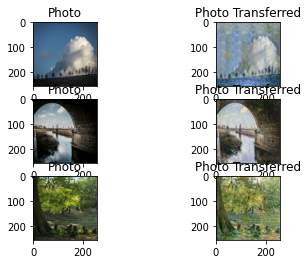

In [17]:
for i, img in enumerate(photo.take(3)):
    prediction = Mt_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    plt.subplot(3,2,2*i+1)
    plt.title('Photo')
    plt.imshow(img)
    plt.subplot(3,2,2*i+2)
    plt.title('Photo Transferred')
    plt.imshow(prediction)

# Create submission file

In [18]:
import PIL
! mkdir ../images
i = 1
for img in photo_test:
    prediction = Mt_generator(img, training=False)[0].numpy()
    im = PIL.Image.fromarray((prediction * 127.5 + 127.5).astype(np.uint8))
    im.save("../images/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'